In [49]:
!pip install python-chess

In [50]:
import chess
import chess.pgn
from chess import Board, Move
from enum import Enum
from google.colab import drive
import io
import itertools
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Iterator, List

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
class ChessMoveModel(nn.Module):
    def __init__(self, number_of_possible_moves):
        super(ChessMoveModel, self).__init__()

        # Convulutional Layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * 8 * 2, 512)
        self.fc2 = nn.Linear(512, number_of_possible_moves)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1) # Flatten from (8, 8, 2) to (128,)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)           #  Output logits for the predicted move

        return x

In [53]:
# Load your trained model
model = ChessMoveModel(number_of_possible_moves=4612)
model.load_state_dict(torch.load('/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/models/cnn.10.27.12.13.pytorch'))
model.eval()  # Set the model to evaluation mode

<ipython-input-53-33cac609f578>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/mode

ChessMoveModel(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4612, bias=True)
)

In [54]:
def prepare_input_tensor(board: chess.Board) -> torch.Tensor:
    # Convert the board state to a PyTorch tensor (assuming get_board_array returns a NumPy array)
    board_tensor = torch.tensor(get_board_array(board), dtype=torch.float32)
    # Create a tensor for the player turn
    turn_tensor = torch.full((8, 8), 1 if board.turn == chess.WHITE else -1, dtype=torch.float32)

    # Stack board and turn tensors along the channel dimension
    input_tensor = torch.stack([board_tensor, turn_tensor], dim=0)  # Shape: (2, 8, 8)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension -> (1, 2, 8, 8)

    return input_tensor

In [55]:
# Define piece to integer mapping
piece_to_int = {
    None: 0,  # Empty square
    chess.PAWN: 1,
    chess.KNIGHT: 2,
    chess.BISHOP: 3,
    chess.ROOK: 4,
    chess.QUEEN: 5,
    chess.KING: 6
}

In [56]:
# Separate for white and black pieces
piece_to_int_white = {piece: val for piece, val in piece_to_int.items()}
piece_to_int_black = {piece: -val for piece, val in piece_to_int.items()}

In [57]:
def get_board_array(board: Board) -> np.ndarray:
    board_array = np.zeros((8, 8), dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece:
            row, col = divmod(square, 8)

            if piece.color == chess.WHITE:
                board_array[row, col] = piece_to_int_white[piece.piece_type]
            else:
                board_array[row, col] = piece_to_int_black[piece.piece_type]

    return board_array

In [58]:
def generate_all_possible_moves():
    file_path = "possible_moves.txt"

    with open(file_path, "r") as file:
        moves = file.readlines()

    return [move.strip() for move in moves]

In [59]:
POSSIBLE_MOVES = generate_all_possible_moves()

In [60]:
def get_move_mask(board: Board) -> np.ndarray:
    move_mask = np.zeros(len(POSSIBLE_MOVES))
    possible_moves = generate_all_possible_moves()

    legal_moves = list(board.legal_moves)

    legal_uci_moves = [move.uci().lower() for move in legal_moves]

    for i, move in enumerate(possible_moves):
        if move in legal_uci_moves:
            move_mask[i] = 1

    return move_mask

In [61]:
def make_move(board: Board) -> str:
  input_tensor = prepare_input_tensor(board)

  with torch.no_grad():
      outputs = model(input_tensor)  # Shape: (1, num_possible_moves)

  outputs

  # Generate the legal move mask for the current board state
  move_mask = get_move_mask(board)   # Legal move mask

  # Apply the mask to the outputs
  masked_outputs = outputs * torch.tensor(move_mask, dtype=torch.float32)

  # Get the best move index
  _, best_move_index = masked_outputs.max(dim=1)

  # Map the best move index back to UCI format
  predicted_move = POSSIBLE_MOVES[best_move_index.item()]

  return predicted_move

In [62]:
def human_move(board: Board, move: str) -> Board:
  move = chess.Move.from_uci(move)
  board.push(move)

  return board

In [63]:
def computer_move(board: Board) -> Board:
  move = make_move(board)
  print(f"Computer: {move}")

  board.push(chess.Move.from_uci(move))

  return board

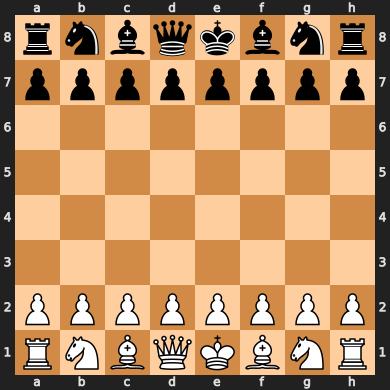

In [64]:
# Create a new chess board (starting position)
board = chess.Board()
board

Computer: b1c3


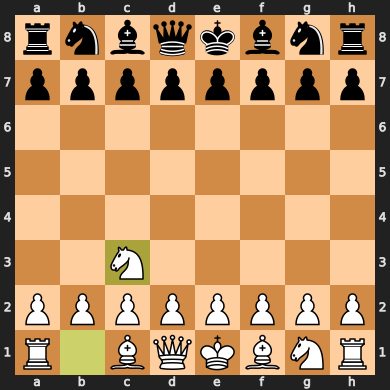

In [65]:
computer_move(board)

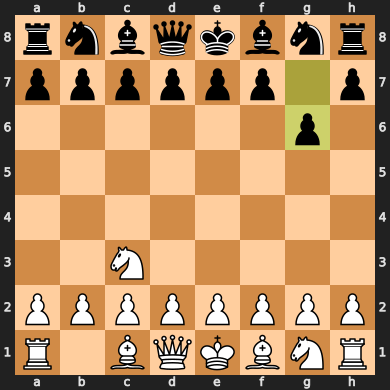

In [66]:
human_move(board, "g7g6")

Computer: e2e4


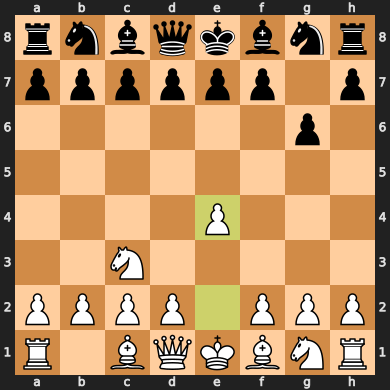

In [67]:
computer_move(board)

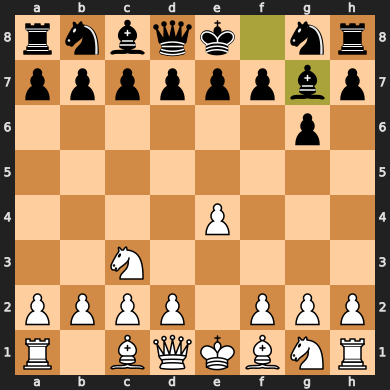

In [68]:
human_move(board, "f8g7")

Computer: g1f3


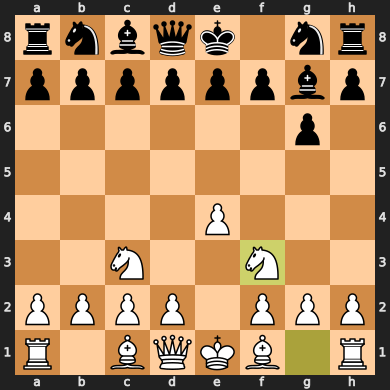

In [69]:
computer_move(board)

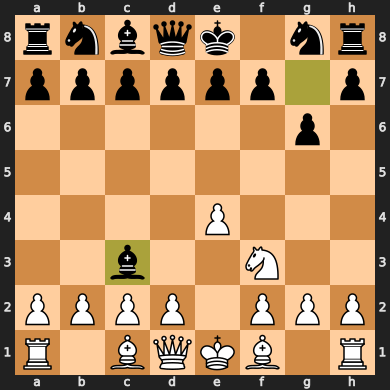

In [70]:
human_move(board, "g7c3")

Computer: b2b4


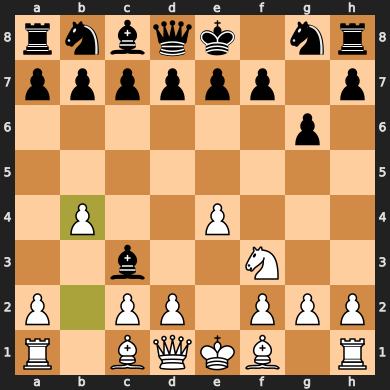

In [71]:
computer_move(board)

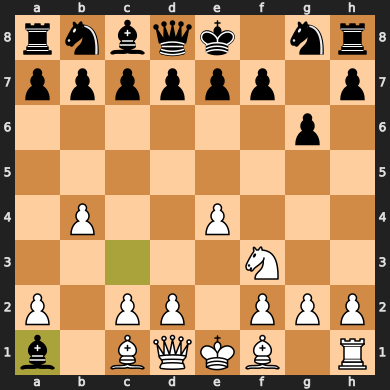

In [72]:
human_move(board, "c3a1")

Computer: d2d4


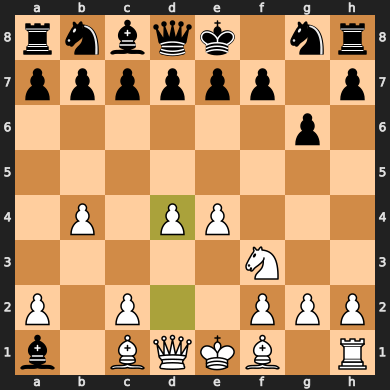

In [73]:
computer_move(board)

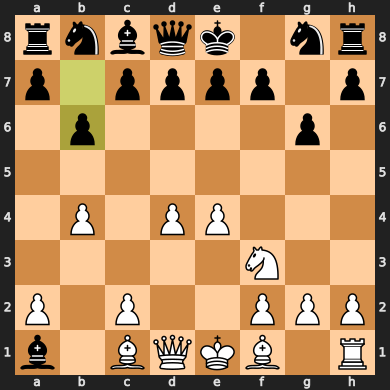

In [74]:
human_move(board, "b7b6")

Computer: f3e5


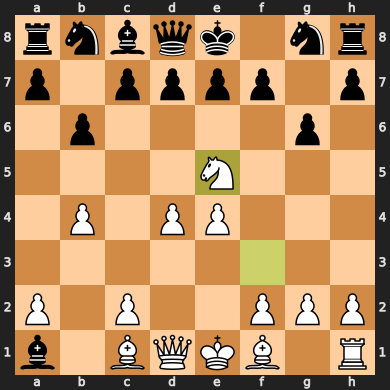

In [75]:
computer_move(board)

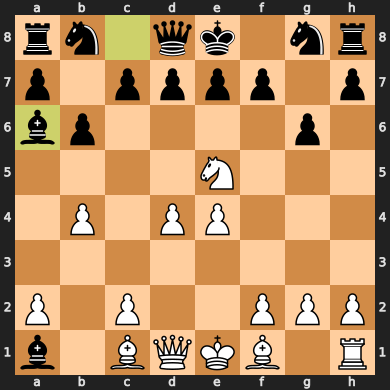

In [76]:
human_move(board, "c8a6")

Computer: d1e2


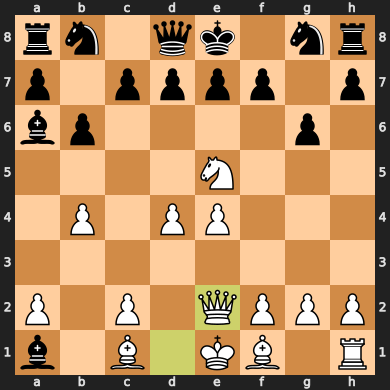

In [77]:
computer_move(board)

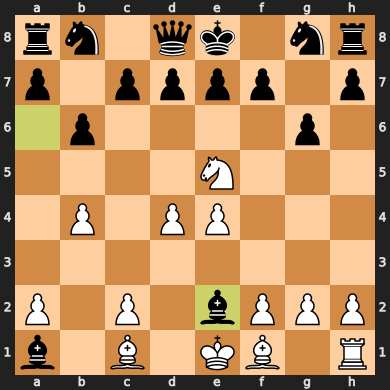

In [78]:
human_move(board, "a6e2")

Computer: g2g4


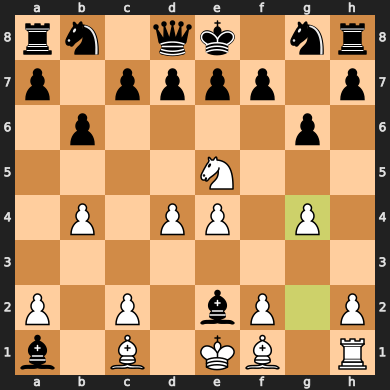

In [79]:
computer_move(board)

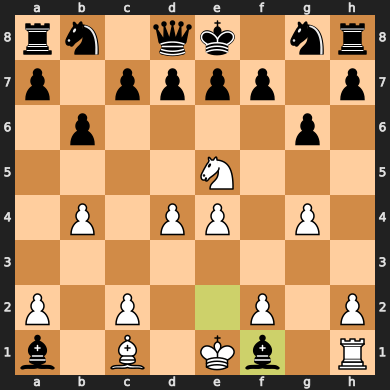

In [80]:
human_move(board, "e2f1")

Computer: a2a3


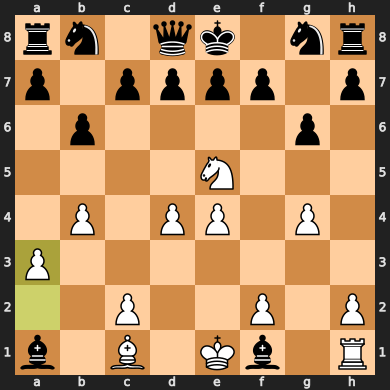

In [81]:
computer_move(board)

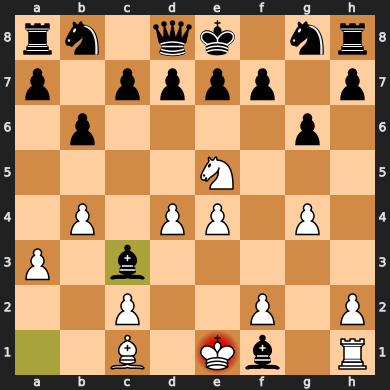

In [82]:
human_move(board, "a1c3")

Computer: c1d2


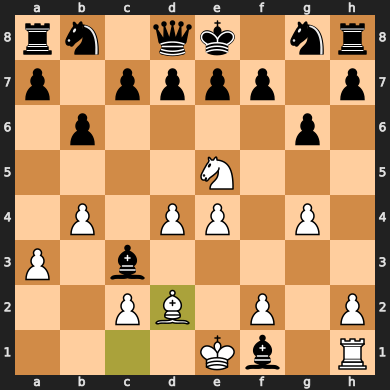

In [83]:
computer_move(board)

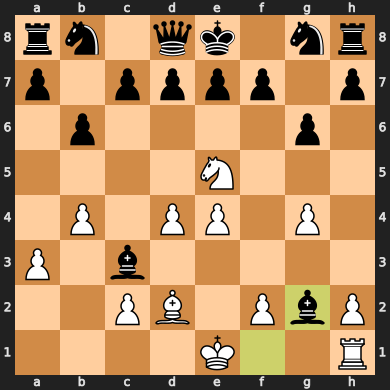

In [84]:
human_move(board, "f1g2")

Computer: f2f4


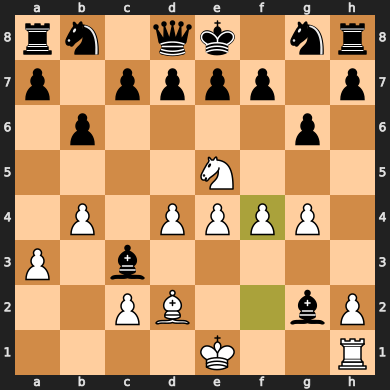

In [85]:
computer_move(board)

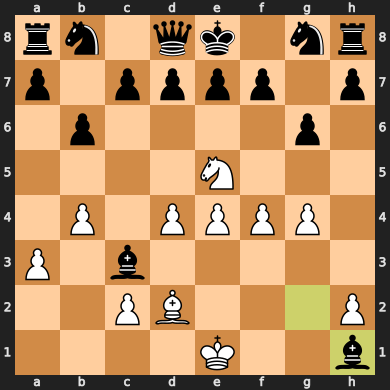

In [86]:
human_move(board, "g2h1")

Computer: h2h4


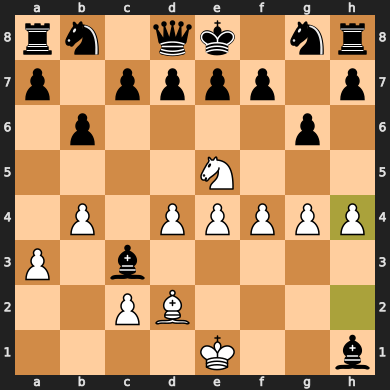

In [87]:
computer_move(board)

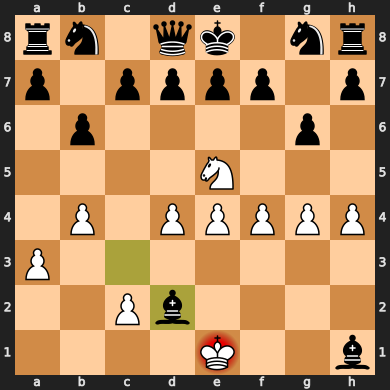

In [88]:
human_move(board, "c3d2")

Computer: e1e2


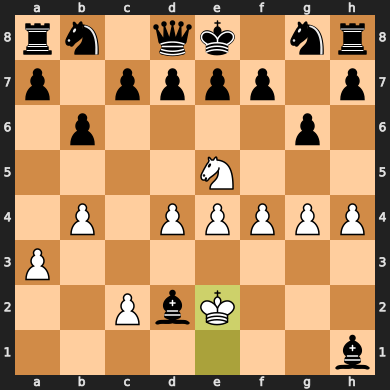

In [89]:
computer_move(board)

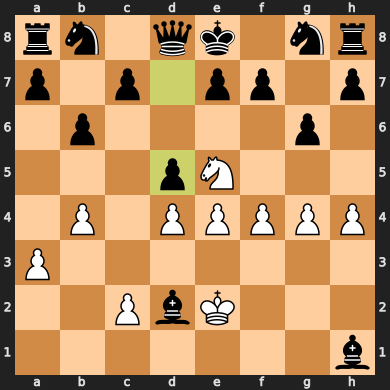

In [90]:
human_move(board, "d7d5")

Computer: e4d5


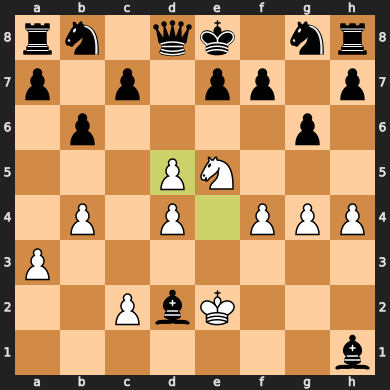

In [91]:
computer_move(board)

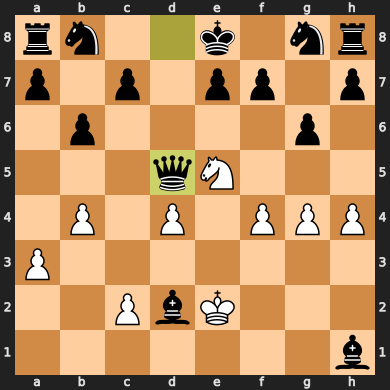

In [92]:
human_move(board, "d8d5")

Computer: c2c3


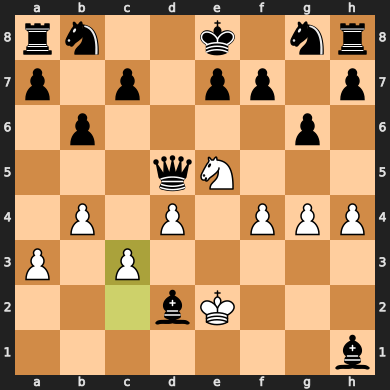

In [93]:
computer_move(board)

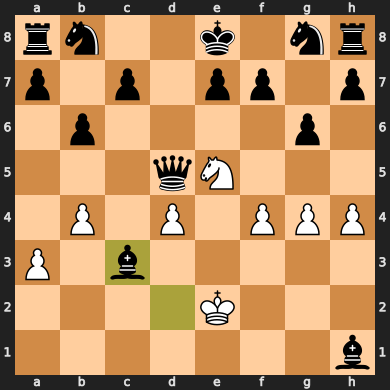

In [94]:
human_move(board, "d2c3")

Computer: g4g5


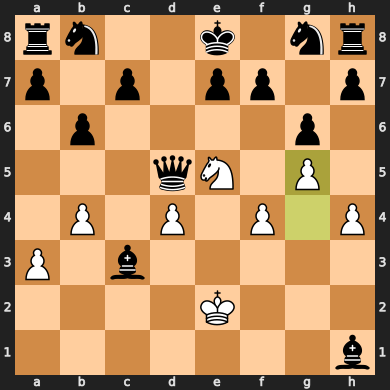

In [95]:
computer_move(board)

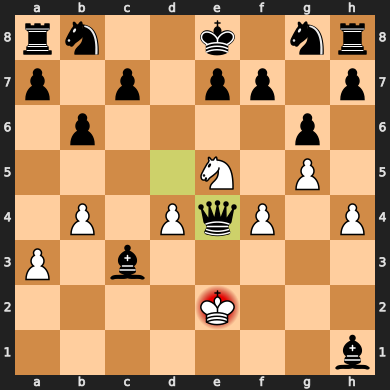

In [96]:
human_move(board, "d5e4")

Computer: e2d1


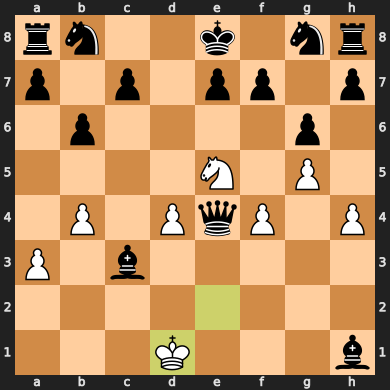

In [97]:
computer_move(board)

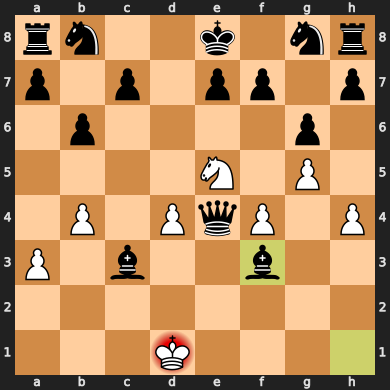

In [98]:
human_move(board, "h1f3")

Computer: e5f3


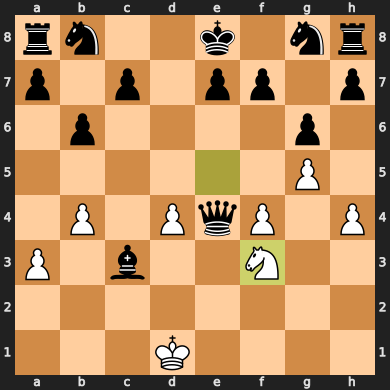

In [99]:
computer_move(board)

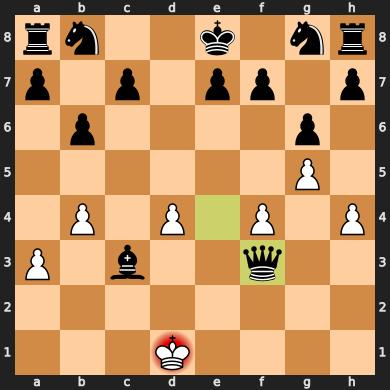

In [100]:
human_move(board, "e4f3")

Computer: d1c2


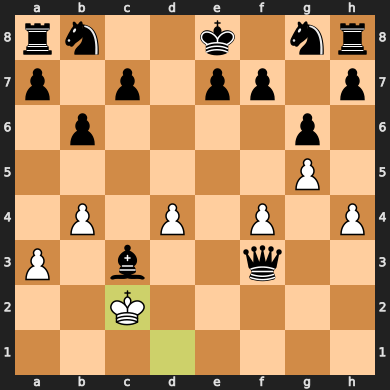

In [101]:
computer_move(board)

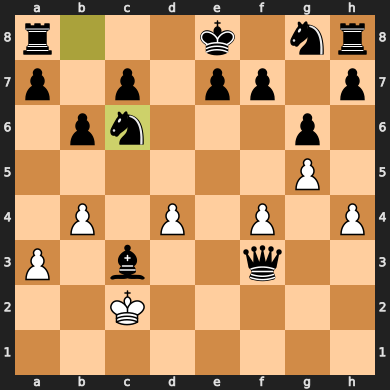

In [102]:
human_move(board, "b8c6")

Computer: d4d5


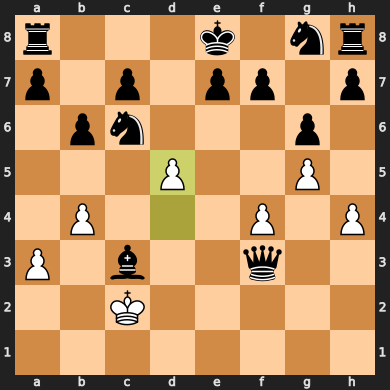

In [103]:
computer_move(board)

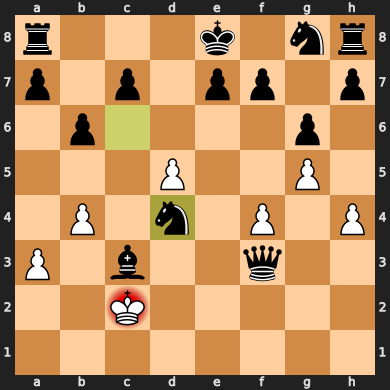

In [104]:
human_move(board, "c6d4")

Computer: c2c1


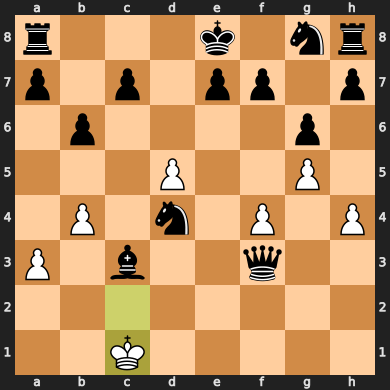

In [105]:
computer_move(board)

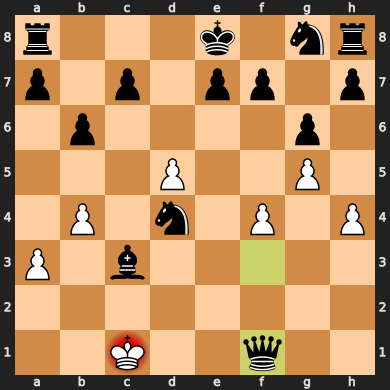

In [106]:
human_move(board, "f3f1")